# 1. Import Dataset & Packages

## 1.1 Import Packages

In [1]:
import pandas as pd # manipulate dataframe
import numpy as np # array, linear algebra

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Web Scraping
import requests
from bs4 import BeautifulSoup

# Make web scraping 10 times faster
import lxml
import cchardet

from datetime import date # get today's date for most updated data

# Hide warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Run and display all commands in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1.2 Web Scraping

In [3]:
# Scrape data from IMDB movie database

# 1st pass requirements: Movie, English language, rating 4+, year 2018+, scrape 1st 3000 movies by popularity
# 2nd pass requirements: same as 1st, add concurrent thread for faster scraping
# Link to scrape: https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,2022-02-17&user_rating=4.0,&languages=en
# Link to go to next page, each page display only 50 movies: https://www.imdb.com/search/title/?title_type=feature&release_date=2019-01-01,2022-02-17&user_rating=4.0,&languages=en&start=51&ref_=adv_nxt

# Create empty array to store information:
movie_name = []
year = []
runtime=[]
rating=[]
metascore =[]
stars=[]
synopsis = []
genre=[]

# Create condition for scraping:
# Link to get customized header: https://www.whatismybrowser.com/detect/what-http-headers-is-my-browser-sending
my_headers ={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:96.0) Gecko/20100101 Firefox/96.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8'
}

today = date.today().strftime("%Y-%m-%m") # Get today's date to get most relevant data
pages = np.arange(1,1000,250) #array of number of movies to impute to link to get next 250 movies

for page in pages:
    page = requests.get('https://www.imdb.com/search/title/?title_type=feature&release_date=2018-01-01,' +str(today) +
                        '&user_rating=4.0,&languages=en&count=250&start=' +str(page)+'&ref_=adv_nxt')
#    soup = BeautifulSoup(page.text, 'html.parser')
    soup = BeautifulSoup(page.text, 'lxml')
    movies = soup.findAll('div', class_ ='lister-item mode-advanced')

    for movie in movies:
        movie_name.append(movie.h3.a.text) # Get movie name
        year.append(movie.h3.text[-6:-2]) # Get year 
        runtime.append(movie.find('span', class_ ='runtime').text if movie.find('span', class_ ='runtime') else 'NA')  # Get runtime 
        rating.append(movie.find('div', class_ = "inline-block ratings-imdb-rating").text.replace('\n', '') if movie.find('div', class_ ="inline-block ratings-imdb-rating") else 'NA') # Get rating
        metascore.append(movie.find('span', class_ = "metascore").text if movie.find('span', class_ = "metascore") else 'NA') # Get metascore
        synopsis.append(movie.find_all('p', class_ ='text-muted')[1].text.replace('\n','')) # Get synopsis
        genre.append(movie.find('span', class_ ='genre').text.replace('\n','') if movie.find('span', class_ ='genre') else 'NA') # Get genre
        stars.append([x.text for x in d] if (d := movie.select('a[href*="_dr_"]')) else None)

%time

Wall time: 0 ns


In [4]:
movies = pd.DataFrame({"Movie_Name": movie_name, 
                        "Release_Year" : year, 
                        "Runtime": runtime,
                       "Genre": genre,
                       "Movie_Rating": rating, 
                       "Critic_Rating": metascore,
                       "Stars": stars,
                       "Synopsis": synopsis})

In [5]:
len(movies)

1000

In [6]:
movies.tail()

,Movie_Name,Release_Year,Runtime,Genre,Movie_Rating,Critic_Rating,Stars,Synopsis
995,Rise of the Footsoldier: Origins,2021,107 min,"Action, Crime, Drama",6.3,NA,None,"The origin story of how Tucker, Rolfie, and Pa..."
996,Misbehaviour,2020,106 min,"Comedy, Drama, History",6.3,62,None,A group of women hatch a plan to disrupt the 1...
997,Falling,2020,112 min,Drama,6.5,63,None,John Peterson lives with his partner Eric and ...
998,Amulet,2020,99 min,"Horror, Mystery",4.8,62,None,"An ex-soldier, living homeless in London, is o..."
999,The Postcard Killings,2020,104 min,"Crime, Drama, Thriller",5.8,29,None,A New York detective investigates the death of...


## Summary

In [236]:
movies.head(2)
movies.info()
movies.describe()

,Movie_Name,Release_Year,Runtime,Genre,Movie_Rating,Critic_Rating,Stars,Synopsis
0,Nightmare Alley,2021,150 min,"Crime, Drama, Thriller",7.2,70,None,An ambitious carny with a talent for manipulat...
1,The Power of the Dog,2021,126 min,"Drama, Romance, Western",6.9,89,None,Charismatic rancher Phil Burbank inspires fear...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Movie_Name     70000 non-null  object
 1   Release_Year   70000 non-null  object
 2   Runtime        70000 non-null  object
 3   Genre          70000 non-null  object
 4   Movie_Rating   70000 non-null  object
 5   Critic_Rating  70000 non-null  object
 6   Stars          0 non-null      object
 7   Synopsis       70000 non-null  object
dtypes: object(8)
memory usage: 4.3+ MB


,Movie_Name,Release_Year,Runtime,Genre,Movie_Rating,Critic_Rating,Stars,Synopsis
count,70000,70000,70000,70000,70000,70000,0,70000
unique,9798,9,161,476,61,89,0,9756
top,The Invisible Man,2021,109 min,Drama,7.3,NA,NaN,Add a Plot
freq,242,31829,2985,4559,3785,12111,NaN,243


# Data Manipulation

In [6]:
# Keep certain columns in casts dataframe
# Keep only the lead and first two supporting roles
casts = casts[[
    'id', 'actor1_name', 'actor2_name', 'actor3_name', 'director_name'
]]

# Keep certain columns in tmdb Dataframe
tmdb.head(2)
tmdb = tmdb[['id', 'overview', 'production_companies', 'production_countries']]

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
0,2,0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,...,69.0,suomi,Released,NaN,Ariel,7.1,40,2,1,2
1,3,0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,...,76.0,English,Released,NaN,Shadows in Paradise,7.0,32,1,1,3


In [9]:
df.head(2)

,movieId,title,genres,tmdbId,id,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,862.0,"Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,United States of America,Tom Hanks,Tim Allen,Don Rickles,John Lasseter,pixar fun,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844.0,8844.0,When siblings Judy and Peter discover an encha...,TriStar Pictures,United States of America,Robin Williams,Jonathan Hyde,Kirsten Dunst,Joe Johnston,fantasy magic board game Robin Williams game,1995


# Data Exploratory Analysis

## Combined (Df) Dataframe

In [10]:
df.shape
df.info()

(9742, 14)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieId               9742 non-null   int64  
 1   title                 9742 non-null   object 
 2   genres                9742 non-null   object 
 3   tmdbId                9734 non-null   float64
 4   id                    9637 non-null   float64
 5   overview              9613 non-null   object 
 6   production_companies  9637 non-null   object 
 7   production_countries  9637 non-null   object 
 8   actor1_name           9637 non-null   object 
 9   actor2_name           9637 non-null   object 
 10  actor3_name           9637 non-null   object 
 11  director_name         9637 non-null   object 
 12  tag                   1572 non-null   object 
 13  year                  9742 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 1.1+ MB


In [11]:
# Drop unused columns
df.drop(columns=['tmdbId', 'id'], inplace=True)

# Find how many NaN value and fill them with blank
df.isna().sum()
df = df.fillna('')
df.isna().sum()

movieId                    0
title                      0
genres                     0
overview                 129
production_companies     105
production_countries     105
actor1_name              105
actor2_name              105
actor3_name              105
director_name            105
tag                     8170
year                       0
dtype: int64

movieId                 0
title                   0
genres                  0
overview                0
production_companies    0
production_countries    0
actor1_name             0
actor2_name             0
actor3_name             0
director_name           0
tag                     0
year                    0
dtype: int64

In [12]:
# Remove 'none' instance with empty string in selected columns
for i in [
        'production_companies', 'production_countries', 'actor1_name',
        'actor2_name', 'actor3_name', 'director_name', 'tag'
]:
    df.loc[df[i].astype(str) == 'none', i] = ''

In [13]:
df.head(2)

,movieId,title,genres,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",Pixar Animation Studios,United States of America,Tom Hanks,Tim Allen,Don Rickles,John Lasseter,pixar fun,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...,TriStar Pictures,United States of America,Robin Williams,Jonathan Hyde,Kirsten Dunst,Joe Johnston,fantasy magic board game Robin Williams game,1995


<AxesSubplot:xlabel='count', ylabel='actor1_name'>

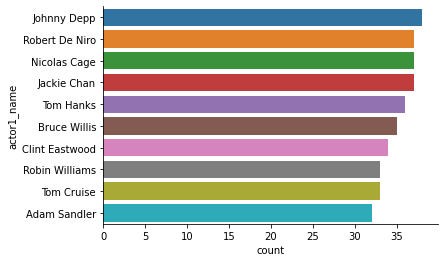

In [17]:
sns.countplot(y=df['actor1_name'],
              order=df['actor1_name'].value_counts().iloc[1:11].index)
sns.despine(top=True, right=True)

In [23]:
genres = [
    'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

genres_rating_list = []

for i in range(len(genres)):
    fil = genres[i] + '_filter'
    mov = genres[i] + '_movies'
    rat = genres[i] + '_ratings'
    rat_mean = rat + '_mean'
    fil = movies['genres'].str.contains(genres[i])
    mov = movies[fil]
    rat = mov.merge(ratings, on='movieId', how='inner')
    rat_mean = round(rat['rating'].mean(), 2)
    genres_rating_list.append(rat_mean)

genres_rating = {'Genre': genres, 'Genres Mean Rating': genres_rating_list}
genres_rating = pd.DataFrame(genres_rating)

<AxesSubplot:xlabel='Genre', ylabel='Genres Mean Rating'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Action'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Animation'),
  Text(3, 0, 'Children'),
  Text(4, 0, 'Comedy'),
  Text(5, 0, 'Crime'),
  Text(6, 0, 'Documentary'),
  Text(7, 0, 'Drama'),
  Text(8, 0, 'Fantasy'),
  Text(9, 0, 'Film-Noir'),
  Text(10, 0, 'Horror'),
  Text(11, 0, 'Musical'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Romance'),
  Text(14, 0, 'Sci-Fi'),
  Text(15, 0, 'Thriller'),
  Text(16, 0, 'War'),
  Text(17, 0, 'Western')])

(3.0, 4.0)

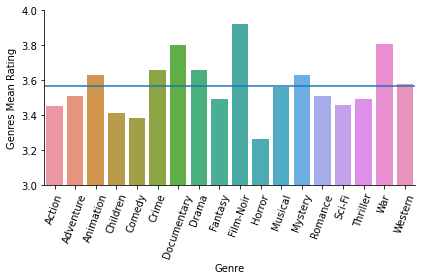

In [24]:
sns.barplot(x='Genre', y='Genres Mean Rating', data=genres_rating)
plt.xticks(rotation=70)
plt.ylim([3, 4])
plt.tight_layout()
plt.axhline(genres_rating['Genres Mean Rating'].mean())
sns.despine(top=True, right=True)
plt.show()

In [25]:
genres = movies.genres.str.get_dummies()
genres = genres.drop(columns=['(no genres listed)', 'IMAX'])
genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
total = genres.sum()

In [27]:
total.sort_values(ascending=False)

Drama          4361
Comedy         3756
Thriller       1894
Action         1828
Romance        1596
Adventure      1263
Crime          1199
Sci-Fi          980
Horror          978
Fantasy         779
Children        664
Animation       611
Mystery         573
Documentary     440
War             382
Musical         334
Western         167
Film-Noir        87
dtype: int64

<AxesSubplot:>

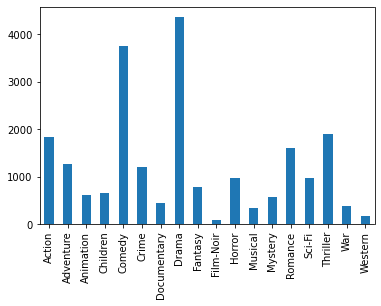

In [28]:
total.plot(kind='bar')

In [29]:
genres_rating['Genres Mean Rating'].mean()

3.5672222222222225

# Content-Based Recommender using Cosine Similarity

## Recommender using Synopsis

In [30]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(9742, 30537)

In [31]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
cosine_sim.shape

(9742, 9742)

In [33]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['title']).drop_duplicates()
indices[:10]

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
Heat (1995)                           5
Sabrina (1995)                        6
Tom and Huck (1995)                   7
Sudden Death (1995)                   8
GoldenEye (1995)                      9
dtype: int64

In [34]:
def get_recommendations(title, cosine_sim=cosine_sim):
    #Get index of the movie with the input title
    idx = indices[title]

    #Get the cosine similarity pairwise score of the movie vs others
    scores = cosine_sim[idx]  #this is an array

    #Create a list with index for the pairwise score
    sim_scores = list(enumerate(
        scores))  # enumerate creates the index, list creates the list

    #Sort the movies based on similarity scores
    sim_scores = sorted(
        sim_scores,
        key=lambda list: list[1],  #sort by score (2nd position of the list)
        reverse=True)  #sort from highest to lowest

    #Get the scores of the top 10 most similar movies
    sim_scores = sim_scores[1:11]  #this is a list

    #Get the indices of those similar movies to get their names
    movie_indices = [i[0] for i in sim_scores]  #this is an array

    #Return the names of the top 10 similar movies
    return df['title'].iloc[movie_indices]

## Improve Cosine Similarity with Credits, Genres and Keyword

In [35]:
df['genres_split'] = df['genres'].str.replace('|', " ", regex=True)

In [36]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [37]:
# Apply clean_data function to features
features = [
    'production_companies', 'production_countries', 'actor1_name',
    'actor2_name', 'actor3_name', 'director_name', 'tag'
]

for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [38]:
df.head(2)

,movieId,title,genres,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year,genres_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",pixaranimationstudios,unitedstatesofamerica,tomhanks,timallen,donrickles,johnlasseter,pixarfun,1995,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...,tristarpictures,unitedstatesofamerica,robinwilliams,jonathanhyde,kirstendunst,joejohnston,fantasymagicboardgamerobinwilliamsgame,1995,Adventure Children Fantasy


In [39]:
df['soup'] = df['overview'] + " " + df['production_countries'] + " " + 
             df['production_companies'] + " " + df['actor1_name'] + " " + 
             df['actor2_name'] + " " + df['actor3_name'] + " " + 
             df['director_name'] + " " + df['year'] + " " + df['genres_split'] + " " + 
             df['tag']

In [40]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [41]:
count_matrix.shape

(9742, 48021)

In [42]:
count_matrix.indices

array([25558, 47262,  2297, ..., 36099, 42447, 22128])

In [43]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [44]:
df.head(2)

,movieId,title,genres,overview,production_companies,production_countries,actor1_name,actor2_name,actor3_name,director_name,tag,year,genres_split,soup
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",pixaranimationstudios,unitedstatesofamerica,tomhanks,timallen,donrickles,johnlasseter,pixarfun,1995,Adventure Animation Children Comedy Fantasy,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...,tristarpictures,unitedstatesofamerica,robinwilliams,jonathanhyde,kirstendunst,joejohnston,fantasymagicboardgamerobinwilliamsgame,1995,Adventure Children Fantasy,When siblings Judy and Peter discover an encha...


In [45]:
get_recommendations('Toy Story (1995)', cosine_sim)

7355                Toy Story 3 (2010)
2355                Toy Story 2 (1999)
5972    40-Year-Old Virgin, The (2005)
840       Rebel Without a Cause (1955)
2392            Man on the Moon (1999)
6343     For Your Consideration (2006)
9207       Welcome to Happiness (2015)
1512                  Condorman (1981)
427                      Malice (1993)
6421               Factory Girl (2006)
Name: title, dtype: object

In [46]:
get_recommendations('Toy Story (1995)', cosine_sim2)

2355                                   Toy Story 2 (1999)
7355                                   Toy Story 3 (2010)
5972                       40-Year-Old Virgin, The (2005)
7733                                 Puss in Boots (2011)
8385                         Mr. Peabody & Sherman (2014)
9586           In the blue sea, in the white foam. (1984)
3568                                Monsters, Inc. (2001)
8715                                 Halloweentown (1998)
8219                                         Turbo (2013)
585     Wallace & Gromit: The Best of Aardman Animatio...
Name: title, dtype: object

# Save model for reuse

In [39]:
import pickle

In [40]:
filename = 'content_based_imdb_webscraping_model.sav'
pickle.dump(svd, open(filename, 'wb'))